<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AE (AutoEncoder)

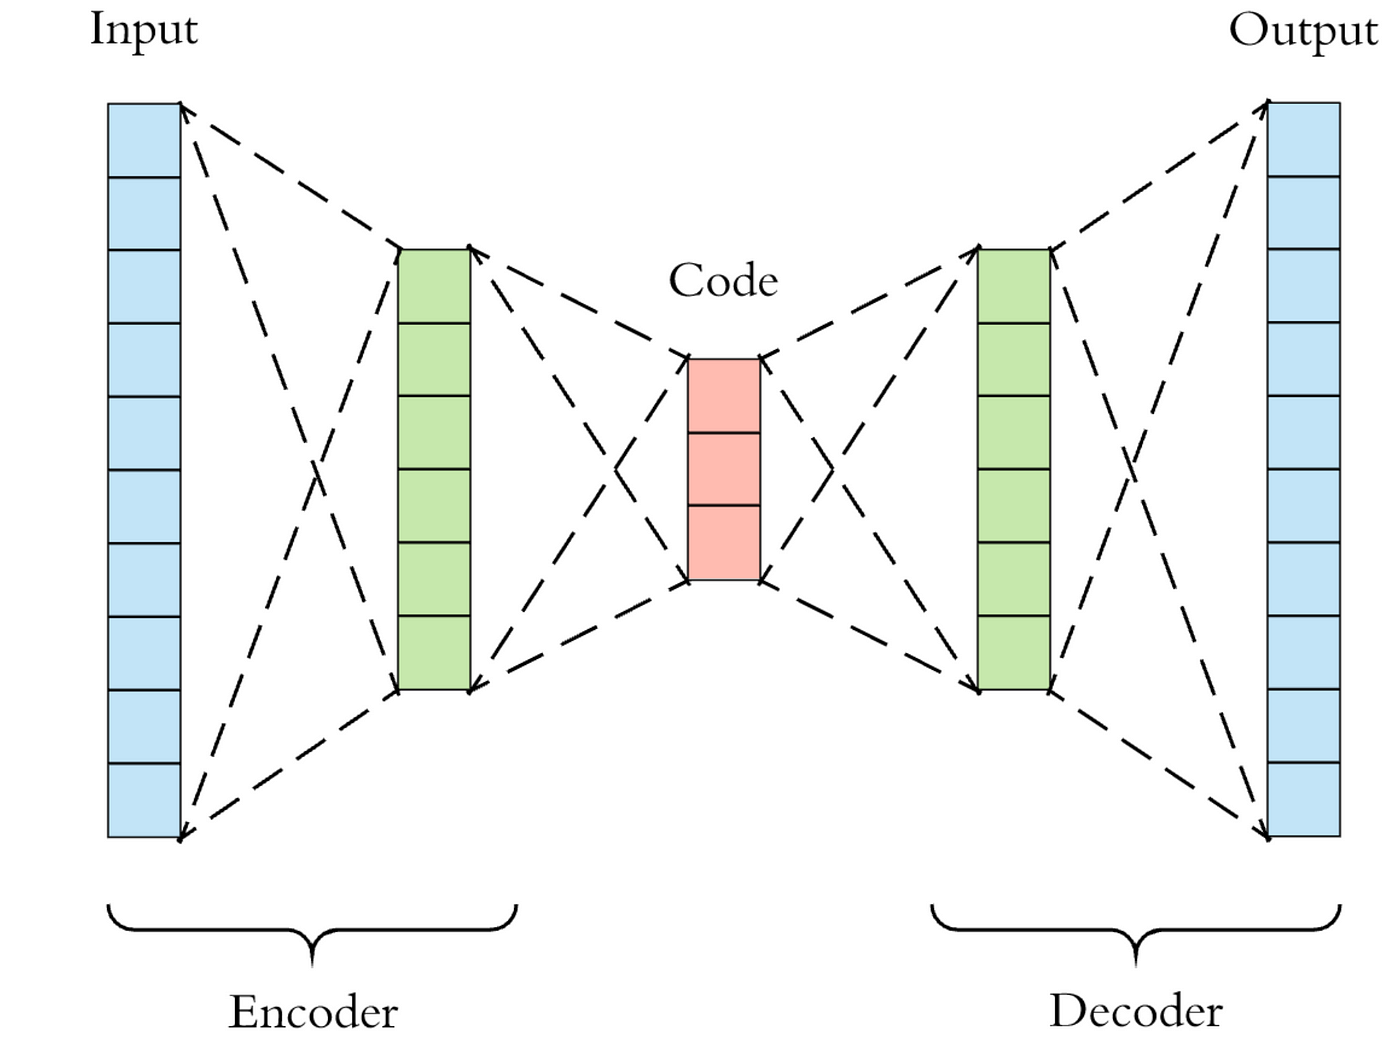

In [6]:
''' import '''
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from sklearn.manifold import TSNE

from utils import set_all, load_data, split_data, check_data, train, evaluate, plot_hist

In [7]:
''' set '''
device, data_path, output_path = set_all(os.getcwd())

In [8]:
''' load data '''
X, Y = load_data(data_path, '3000')
X = X / 255.0
X_tr, X_ts, Y_tr, Y_ts = split_data(X,Y, test_size=0.2, device=device, flatten=True)

print(X_tr.shape, X_ts.shape)
print (Y_tr.shape,Y_ts.shape)

torch.Size([2400, 3136]) torch.Size([600, 3136])
torch.Size([2400, 1]) torch.Size([600, 1])


In [9]:
# check_data(X,Y)

In [10]:
''' model '''
class Autoencoder(nn.Module):
    def __init__(self, enc_fts, dec_fts=None):
        super(Autoencoder, self).__init__()

        if enc_fts is None:
            dec_fts = enc_fts[::-1]

        # encoder
        self.encoder = nn.ModuleList()
        in_ft = enc_fts[0]

        for i in range(len(enc_fts)-2): # relu o
            out_ft = enc_fts[i+1]
            self.encoder.append(nn.Linear(in_ft, out_ft))
            self.encoder.append(nn.ReLU())
            in_ft = out_ft
        
        out_ft = enc_fts[-1] # relu x
        self.encoder.append(nn.Linear(in_ft, out_ft))
        
        # decoder
        self.decoder = nn.ModuleList()
        in_ft = out_ft # dec_fts[0]

        for i in range(len(dec_fts)-1): # relu o
            out_ft = dec_fts[i+1]
            self.decoder.append(nn.Linear(in_ft, out_ft))
            self.decoder.append(nn.ReLU())
            in_ft = out_ft

        out_ft = dec_fts[-1] # relu x
        self.decoder.append(nn.Linear(in_ft, out_ft))

    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
        for layer in self.decoder:
            x = layer(x)
        return x

In [11]:
# ae = Autoencoder(enc_fts=[56*56, 512, 256, 20], dec_fts=[20, 256, 512, 56*56]).to(device)

# summary(ae, (3136,))  # input shape: (height*width, )
# ae

In [14]:
''' hyper params '''

# model
ae = Autoencoder(enc_fts=[56*56, 512, 256, 20], dec_fts=[20, 256, 512, 56*56]).to(device)

# hyper param
num_epochs = 50
batch_size = 64
learning_rate = 1e-3

# loss, optim, scaduler
criterion = nn.MSELoss()
optimizer = optim.Adam(params=ae.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.9)

# data loader
train_loader = DataLoader(TensorDataset(X_tr, X_tr), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_ts, X_ts), batch_size=len(X_ts))

In [15]:
''' train '''
loss_tr_hist = []
loss_val_hist = []

for epoch in range(num_epochs):

    # train, valid
    loss_tr = train(ae, train_loader, criterion, optimizer)
    loss_val = evaluate(ae, test_loader, criterion)
    scheduler.step()
    
    # history
    loss_tr_hist.append(loss_tr)
    loss_val_hist.append(loss_val)
    print(f'Epoch [{epoch+1:3}/{num_epochs}], Tr loss: {loss_tr:.5f}, Val loss: {loss_val:.5f}')

Epoch [  1/50], Tr loss: 0.13519, Val loss: 0.09793
Epoch [  2/50], Tr loss: 0.09795, Val loss: 0.09539
Epoch [  3/50], Tr loss: 0.08541, Val loss: 0.07477
Epoch [  4/50], Tr loss: 0.06663, Val loss: 0.05936
Epoch [  5/50], Tr loss: 0.05573, Val loss: 0.05077
Epoch [  6/50], Tr loss: 0.04838, Val loss: 0.04447
Epoch [  7/50], Tr loss: 0.04210, Val loss: 0.04032
Epoch [  8/50], Tr loss: 0.03849, Val loss: 0.03673
Epoch [  9/50], Tr loss: 0.03540, Val loss: 0.03534
Epoch [ 10/50], Tr loss: 0.03329, Val loss: 0.03299
Epoch [ 11/50], Tr loss: 0.03132, Val loss: 0.03167
Epoch [ 12/50], Tr loss: 0.02967, Val loss: 0.03000
Epoch [ 13/50], Tr loss: 0.02813, Val loss: 0.02899
Epoch [ 14/50], Tr loss: 0.02652, Val loss: 0.02793
Epoch [ 15/50], Tr loss: 0.02522, Val loss: 0.02675
Epoch [ 16/50], Tr loss: 0.02402, Val loss: 0.02511
Epoch [ 17/50], Tr loss: 0.02264, Val loss: 0.02503
Epoch [ 18/50], Tr loss: 0.02207, Val loss: 0.02450
Epoch [ 19/50], Tr loss: 0.02123, Val loss: 0.02344
Epoch [ 20/5

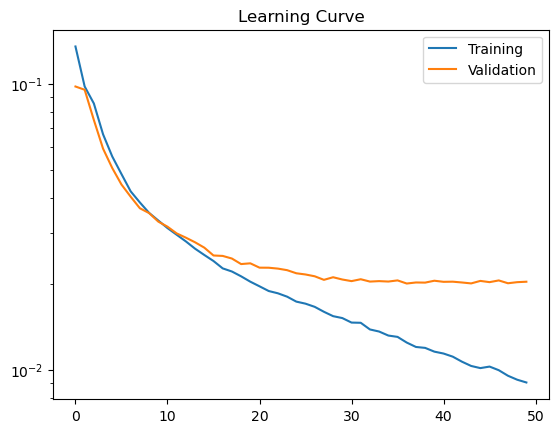

In [16]:
plot_hist(loss_tr_hist, loss_val_hist, title='Learning Curve')

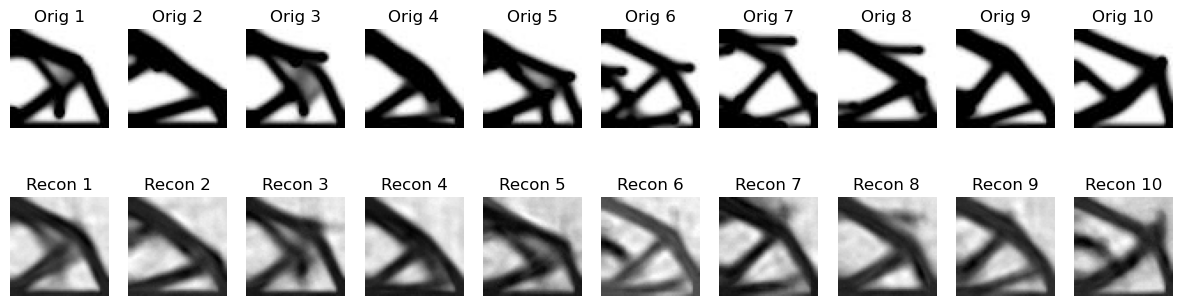

In [17]:
''' evaluation '''
ae.eval()
n = 10

plt.figure(figsize=(15, 4))

for i in range(n):
    
    orig_img = X_ts.cpu()[i].reshape(56,56)
    recon_img = ae(X_ts[i]).detach().cpu().reshape(56,56)

    # original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(orig_img, cmap="gray")
    plt.title(f"Orig {i+1}")
    ax.axis('off')

    # recon
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(recon_img, cmap="gray")
    plt.title(f"Recon {i+1}")
    ax.axis('off')

plt.show()

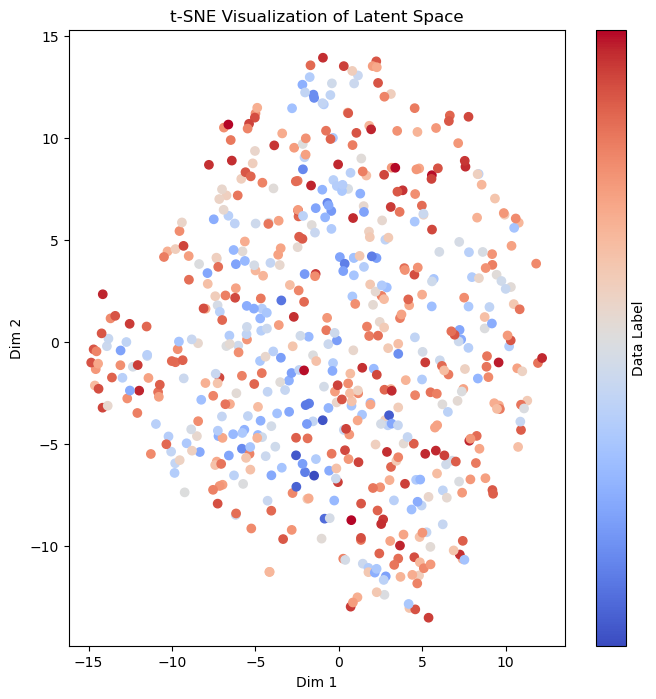

In [18]:
''' visulaize latent space '''
ae.eval()
with torch.no_grad():
    z = X_ts
    for layer in ae.encoder:
        z = layer(z)
    z = z.squeeze().cpu().detach().numpy()   # latent space(z)

# dimension reduction (t-SNE)
tsne = TSNE(n_components=2, perplexity=70, random_state=0) # perplexity : num of neighbors
z_tsne = tsne.fit_transform(z)

# plot
plt.figure(figsize=(8, 8))
scatter = plt.scatter(z_tsne[:,0], z_tsne[:,1], c=Y_ts.cpu(), cmap='coolwarm')

plt.colorbar(scatter, ticks=[0, 50], label='Data Label')
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.title("t-SNE Visualization of Latent Space")
plt.show()